In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import Random
from time import time
from inspyred import ec, benchmarks
from collections import Counter
import statistics

## Problem Class Definition

In [ ]:
class WorkoutRoutine(benchmarks.Benchmark):
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        self.userLevel = userLevel.lower()
        self.time = time  # horas
        self.exercises = exercises  # diccionario {id: ejercicio}
        self.length = time * 6  # máx 6 ejercicios por hora
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        self.maximize = True
        self.bounder = ec.DiscreteBounder(range(len(exercises)))

        self.difficulty_map = {
            "beginner": 0,
            "novice": 1,
            "intermediate": 2,
            "advanced": 3,
            "expert": 4,
            "master": 5
        }


    def generator(self, random, args):
        def clean_equipment(val):
            return str(val).strip().lower() if isinstance(val, str) else ''
    
        requested = {str(m).strip().lower() for m in self.requestMuscles}
        user_eq = {str(e).strip().lower() for e in self.equipment}
        has_gym = any(e.strip().lower() == "gym" for e in self.equipment)

        valid_indices = []
        for i, ex in enumerate(self.exercises):
            if not ex:
                continue

            muscle = str(ex.get('TargetMuscleGroup', '')).strip().lower()
            primary = clean_equipment(ex.get('PrimaryEquipment'))
            secondary = clean_equipment(ex.get('SecondaryEquipment'))
            equipment_needed = {primary, secondary} - {''}

            if not has_gym and not equipment_needed.issubset(user_eq):
                continue
                
            if muscle in requested:
                valid_indices.append(i)  # Always include requested muscle
            else:
                if random.random() < 0.2:  # 20% chance to allow a non-requested muscle
                    valid_indices.append(i)

        if not valid_indices:
            valid_indices = list(range(len(self.exercises)))

        return [random.choice(valid_indices) for _ in range(self.length)]

    
    def evaluator(self, candidates, args):
        fitness = []
        
        if 'metadata' not in args:
            args['metadata'] = {}

        for candidate in candidates:
            routine = self.get_exercises(candidate)
            n = len(routine)

            y_penalties = self.repetition_penalties(candidate)
            
            y_factor = sum(y_penalties) / n
            
            muscles_factor = self.trained_muscles(routine) # porcentaje de músculos entrenados
            
            difficulty_factor = self.difficulty_score(routine)
            
            if not self.equipment == "Gym":
                equipment_factor = self.used_equipment(routine)
            else:
                equipment_factor = 1  # si es gym, no penaliza por equipo

            
            value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
            
            # Bonus
            if value < 100:
                bonus = self.calculate_bonus(routine)
                value = min(value + bonus, 100)
            
             # Asociar la metadata al individuo usando una tupla como clave (para que sea hashable)
            args['metadata'][tuple(candidate)] = {
                'y_factor' : y_factor,
                'muscles_factor': muscles_factor,
                'difficulty_factor': difficulty_factor,
                'equipment_factor': equipment_factor,
                'value': value,
                'bonus': bonus
            }

            fitness.append(value)
        return fitness

    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]

    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, eid in enumerate(candidate):
            for j in range(i):
                if candidate[j] == eid:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.85
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties

    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.05 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)

    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])

        if not self.equipment:
            return 1 if not used else 0  # si no tiene equipo, penaliza cualquier uso

        allowed = set(self.equipment)
        invalid = used - allowed

        # penaliza proporcionalmente según el número de equipos inválidos usados
        total = len(used)
        if total == 0:
            return 1  # no se ha usado equipo
        else:
            penalty = len(invalid) / total
            return 1 - penalty  # cuanto más equipo no disponible, menor la puntuación

    
    # Check the muscle factor calculation
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        # 0. Nueva restricción: al menos 75% de ejercicios deben ser de músculos solicitados
        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.75
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0  # no cumple la condición mínima

        # 1. Cobertura: cuántos músculos solicitados fueron entrenados
        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        # 2. Equilibrio de distribución
        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - (sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej)

        factor = coverage * balance

        return max(min(factor, 1), 0)


    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()

        # Fix: Ensure splitting happens on semicolon, not character-by-character
        if isinstance(self.requestMuscles, str):
            requested = {m.strip().lower() for m in self.requestMuscles.split(';')}
        else:
            requested = {str(m).strip().lower() for m in self.requestMuscles}

        for ex in routine:
            muscle = str(ex['TargetMuscleGroup']).strip().lower()
            region = ex['BodyRegion']
            if muscle not in requested:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)

        return extra_bonus

In [79]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

# Define the problem

In [80]:
# Read user csv
users_df = pd.read_csv("../assets/random_users.csv")

In [81]:
exercises = df.to_dict(orient='records')

row = {
    'userLevel': "intermediate",
    'equipment': "Gym",
    'requestMuscles': "Quadriceps;Chest;Shoulders;Abdominals;Back;Biceps",
    'duration': 5
}


userLevel = row['userLevel'].lower()
equipment = row['equipment'].split(';') if isinstance(row['equipment'], str) else []
requestMuscles = row['requestMuscles'].split(';') if isinstance(row['requestMuscles'], str) else []
duration =  row['duration']  # horas
userID = 14948
problem = WorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)

# Executing the GA

## Algorithm Configurations

In [82]:
from inspyred import ec
from inspyred.ec import selectors, variators, replacers
from inspyred.ec.terminators import generation_termination, no_improvement_termination
from inspyred.ec.variators import random_reset_mutation, inversion_mutation

def tournament_selection_5(random, population, args):
    args = dict(args)
    args['tournament_size'] = 5
    return selectors.tournament_selection(random, population, args)

def tournament_selection_2(random, population, args):
    args = dict(args)
    args['tournament_size'] = 2
    return selectors.tournament_selection(random, population, args)

configurations = {
    1: {
        'pop_size': 2000,
        'crossover_rate': 0.8,
        'mutation_rate': 0.1,
        'num_elites': 2,
        'num_selected': 2000,
        'selector': selectors.tournament_selection,
        'variator': [variators.uniform_crossover, random_reset_mutation],
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {'max_generations_without_improvement': 30},
        'max_generations': 300
    },
    2: {
        'pop_size': 3000,
        'crossover_rate': 0.6,
        'mutation_rate': 0.3,
        'num_elites': 1,
        'num_selected': 3000,
        'selector': selectors.fitness_proportionate_selection,
        'variator': [variators.n_point_crossover, random_reset_mutation],
        'num_crossover_points': 1,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 200
    },
    3: {
        'pop_size': 800,
        'crossover_rate': 0.9,
        'mutation_rate': 0.05,
        'num_elites': 5,
        'num_selected': 800,
        'selector': selectors.rank_selection,
        'variator': [variators.n_point_crossover, random_reset_mutation],
        'num_crossover_points': 2,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 200
    },
    4: {
        'pop_size': 1500,
        'crossover_rate': 0.95,
        'mutation_rate': 0.02,
        'num_elites': 3,
        'num_selected': 1500,
        'selector': tournament_selection_5,
        'variator': [variators.n_point_crossover, inversion_mutation],
        'num_crossover_points': 1,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 250
    },
    5: {
        'pop_size': 1000,
        'crossover_rate': 0.4,
        'mutation_rate': 0.4,
        'num_elites': 2,
        'num_selected': 1000,
        'selector': selectors.fitness_proportionate_selection,
        'variator': [variators.uniform_crossover, inversion_mutation],
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 150
    },
    6: {
        'pop_size': 2000,
        'crossover_rate': 0.7,
        'mutation_rate': 0.2,
        'num_elites': 10,
        'num_selected': 2000,
        'selector': selectors.rank_selection,
        'variator': [variators.n_point_crossover, inversion_mutation],
        'num_crossover_points': 2,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 200
    },
    7: {
        'pop_size': 1200,
        'crossover_rate': 0.85,
        'mutation_rate': 0.15,
        'num_elites': 3,
        'num_selected': 1200,
        'selector': tournament_selection_2,
        'variator': [variators.n_point_crossover, inversion_mutation],
        'num_crossover_points': 2,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 150
    },
    8: {
        'pop_size': 2500,
        'crossover_rate': 0.75,
        'mutation_rate': 0.1,
        'num_elites': 5,
        'num_selected': 2500,
        'selector': selectors.fitness_proportionate_selection,
        'variator': [variators.uniform_crossover, random_reset_mutation],
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 200
    },
    9: {
        'pop_size': 3000,
        'crossover_rate': 1.0,
        'mutation_rate': 0.3,
        'num_elites': 10,
        'num_selected': 3000,
        'selector': selectors.tournament_selection,
        'variator': [variators.n_point_crossover, inversion_mutation],
        'num_crossover_points': 2,
        'replacer': replacers.generational_replacement,
        'terminator': lambda: generation_termination,
        'termination_args': {},
        'max_generations': 300
    }
}


In [83]:
# Initializing the observer
def diversity(population):
    return np.array([i.candidate for i in population]).std(axis=0).mean()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [84]:
def run_ga_with_config(problem, config_id, prng):
    from inspyred import ec
    from inspyred.ec import observers

    config = configurations[config_id]
    ga = ec.GA(prng)

    # Asignar componentes desde la configuración
    ga.selector = config['selector'] if callable(config['selector']) else lambda r, pop, args: config['selector'](r, pop, args)
    ga.variator = config['variator']
    ga.replacer = config['replacer']
    ga.terminator = config['terminator']()
    ga.observer = [fitness_diversity_observer, observers.stats_observer]

    # Historias y metadata
    best_fitness_historic = []
    diversity_historic = []
    evolve_args = {
        'best_fitness_historic': best_fitness_historic,
        'diversity_historic': diversity_historic,
        'metadata': {},
    }

    # Añadir args extra si hay
    evolve_args.update(config.get('termination_args', {}))

    final_pop = ga.evolve(
        generator=problem.generator,
        evaluator=problem.evaluator,
        bounder=problem.bounder,
        maximize=problem.maximize,
        pop_size=config['pop_size'],
        max_generations=config['max_generations'],
        num_elites=config['num_elites'],
        num_selected=config['num_selected'],
        crossover_rate=config['crossover_rate'],
        num_crossover_points=1,
        mutation_rate=config['mutation_rate'],
        **evolve_args
    )

    # Resultados finales
    best = max(ga.population)
    best_data = evolve_args['metadata'].get(tuple(best.candidate), None)

    return {
        'user_id': problem.userID,
        'best_candidate': best.candidate,
        'best_fitness': best.fitness,
        'best_metadata': best_data,
        'history': {
            'fitness': best_fitness_historic,
            'diversity': diversity_historic
        }
    }



## Ejecutando los experimentos

In [107]:
from random import Random
from time import time

seed = 12345 # Fijamos la semilla a un valor fijo para reproducibilidad
prng = Random()
prng.seed(seed)

result = run_ga_with_config(problem, config_id=9, prng=prng)

print("Best fitness:", result['best_fitness'])
print("Best routine:", result['best_candidate'])


Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0       3000 28.7500000 53.5474358 35.7363984 36.0496823 4.50573118

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1       6000 29.2833333 53.5474358       38.7 38.7712023 4.26133556

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2       9000 31.9111111 56.2230769 40.9944444 41.2398371 3.91767776

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3      12000      34.85 58.1179487     43.225 43.3715804 3.64489550

Generation Evaluation      Worst       Best     Median    Average    Std

## Resultados del experimento

In [108]:
print(f"User {result['user_id']} - Best Fitness: {result['best_fitness']}")
print(f"User {result['user_id']} - Best Candidate: {result['best_candidate']}")
print(f"User {result['user_id']} - Requested Muscles: {problem.requestMuscles}")
print(f"User {result['user_id']} - Equipment: {problem.equipment}")
print(f"User {result['user_id']} - User Level: {problem.userLevel}")
print(f"User {result['user_id']} - Duration: {problem.time} hours")
print(f"User penalties: {result['best_metadata']}")

# Ordenar la rutina según TargetMuscleGroup
sorted_routine = sorted(result['best_candidate'], key=lambda x: exercises[x]['TargetMuscleGroup'])

for idx in sorted_routine:
    exercise = exercises[idx]
    print(f"\t{exercise['Exercise']} {exercise['TargetMuscleGroup']} - {exercise['DifficultyLevel']} - {exercise['BodyRegion']} - {exercise['PrimaryEquipment']} - {exercise['SecondaryEquipment']}")


User 14948 - Best Fitness: 68.03
User 14948 - Best Candidate: [1729, 1729, 1729, 431, 431, 431, 2072, 2072, 2072, 1854, 1854, 1854, 2006, 2072, 1854, 222, 222, 222, 2539, 2539, 2539, 2539, 1194, 222, 1194, 1657, 1657, 1657, 2769, 2769]
User 14948 - Requested Muscles: ['Quadriceps', 'Chest', 'Shoulders', 'Abdominals', 'Back', 'Biceps']
User 14948 - Equipment: ['Gym']
User 14948 - User Level: intermediate
User 14948 - Duration: 5 hours
User penalties: {'y_factor': 0.9186666666666666, 'muscles_factor': 1.0, 'difficulty_factor': 0.9683333333333334, 'equipment_factor': 1, 'value': 68.03, 'bonus': 0.5}
	Single Arm Clubbell Hammer Swing Abdominals - Intermediate - Full Body - Clubbell - nan
	Single Arm Clubbell Hammer Swing Abdominals - Intermediate - Full Body - Clubbell - nan
	Single Arm Clubbell Hammer Swing Abdominals - Intermediate - Full Body - Clubbell - nan
	Single Arm Clubbell Hammer Swing Abdominals - Intermediate - Full Body - Clubbell - nan
	Single Arm Clubbell Pullover Back - Nov

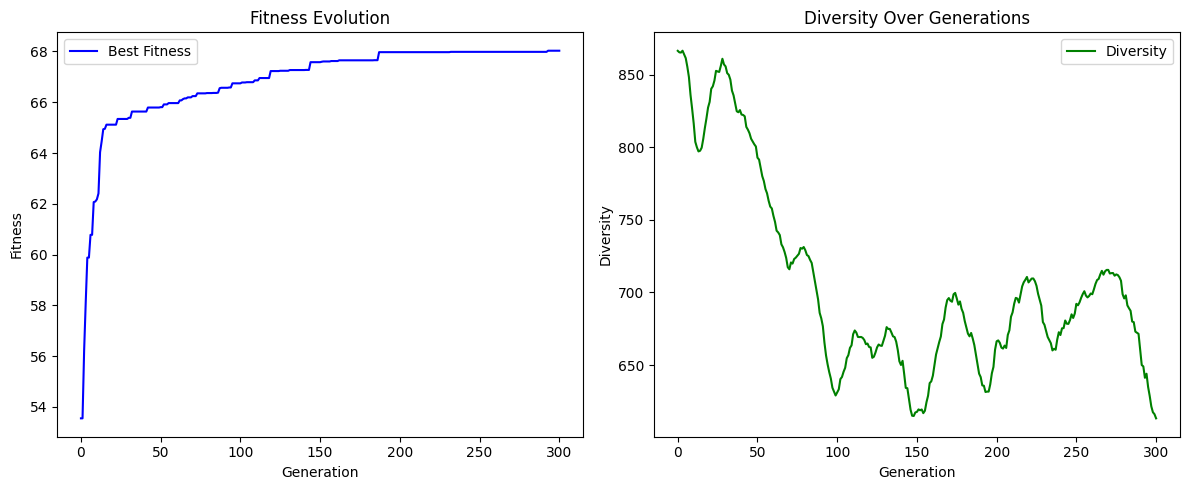

In [109]:
import matplotlib.pyplot as plt

fitness_history = result['history']['fitness']
diversity_history = result['history']['diversity']

plt.figure(figsize=(12, 5))

# Subplot de evolución del fitness
plt.subplot(1, 2, 1)
plt.plot(fitness_history, label='Best Fitness', color='blue')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Evolution')
plt.legend()

# Subplot de evolución de la diversidad
plt.subplot(1, 2, 2)
plt.plot(diversity_history, label='Diversity', color='green')
plt.xlabel('Generation')
plt.ylabel('Diversity')
plt.title('Diversity Over Generations')
plt.legend()

plt.tight_layout()
plt.show()
